In [40]:
!pip install transformers

In [41]:
pip install seqeval

In [42]:
pip install wordcloud

In [43]:
!pip install keras-tuner

In [44]:
!python3 -m spacy download en_core_web_sm

In [45]:
!python3 -m spacy download en_core_web_sm

In [7]:
# Required Libraries
import re
import os
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers.legacy import Adam
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout,SpatialDropout1D, Bidirectional, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras_tuner import BayesianOptimization
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.utils import to_categorical
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
import spacy
from spacy import displacy
from spacy.tokens import Doc, Span
from sklearn.metrics import confusion_matrix
from collections import Counter
from transformers import BertTokenizerFast, TFBertForTokenClassification, AdamW
import kerastuner as kt
#from tensorflow.keras.optimizers import Adam

import torch
from torch.utils.data import DataLoader
from transformers import AdamW
from torch.optim import SGD
from tqdm import tqdm
from transformers import BertForTokenClassification
from transformers import BertTokenizerFast

spacy_nlp = spacy.load('en_core_web_sm')
nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

/tmp/ipykernel_32/193381205.py:40: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [8]:
def set_seeds(seed_value=42):
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

# Call the function at the beginning of your notebook
set_seeds()

In [9]:
# Load Data
annotations = pd.read_csv('amlh_nlp_dataset_2023/amlh_coursework_2023_manuallyannotated.csv')

In [10]:
annotations.head()

,Unnamed: 0,file,start,end,text,class
0,0,3241_General Medicine.txt,1820,1828,cyanosis,Phenotypes
1,1,3241_General Medicine.txt,1327,1344,umbilical hernias,Phenotypes
2,2,3241_General Medicine.txt,1356,1363,ascites,Phenotypes
3,3,3241_General Medicine.txt,1842,1847,edema,Phenotypes
4,4,3241_General Medicine.txt,1526,1534,prostate,Body_parts


## Exploratory Data Analysis

In [11]:
annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16693 entries, 0 to 16692
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  16693 non-null  int64 
 1   file        16693 non-null  object
 2   start       16693 non-null  int64 
 3   end         16693 non-null  int64 
 4   text        16693 non-null  object
 5   class       16693 non-null  object
dtypes: int64(3), object(3)
memory usage: 782.6+ KB


In [12]:
annotations['class'].value_counts()

Phenotypes    7965
Body_parts    6972
Others        1756
Name: class, dtype: int64

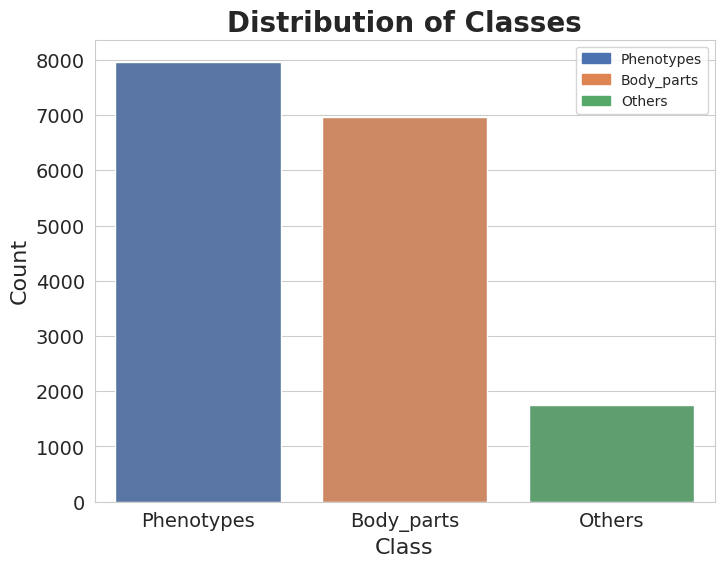

In [13]:
from matplotlib.patches import Patch
# Plot the data
plt.figure(figsize=(8, 6))  # Enlarge the plot size
sns.set_style("whitegrid")  # Set style to whitegrid

# Get colors from the seaborn deep palette
colors = sns.color_palette('deep', len(annotations['class'].value_counts()))

# Create the bar plot with seaborn's 'barplot'
sns.barplot(x=annotations['class'].value_counts().index, y=annotations['class'].value_counts().values, palette=colors)

# Create legend patches
legend_patches = [Patch(color=c, label=l) for c, l in zip(colors, annotations['class'].value_counts().index)]

plt.xlabel('Class', fontsize=16)  # Add label for x-axis
plt.ylabel('Count', fontsize=16)  # Add label for y-axis
plt.title('Distribution of Classes', fontsize=20, fontweight='bold')  # Add title
plt.legend(handles=legend_patches)
plt.xticks(fontsize=14)  # Adjust x-axis tick font size
plt.yticks(fontsize=14)  # Adjust y-axis tick font size

plt.show()


/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


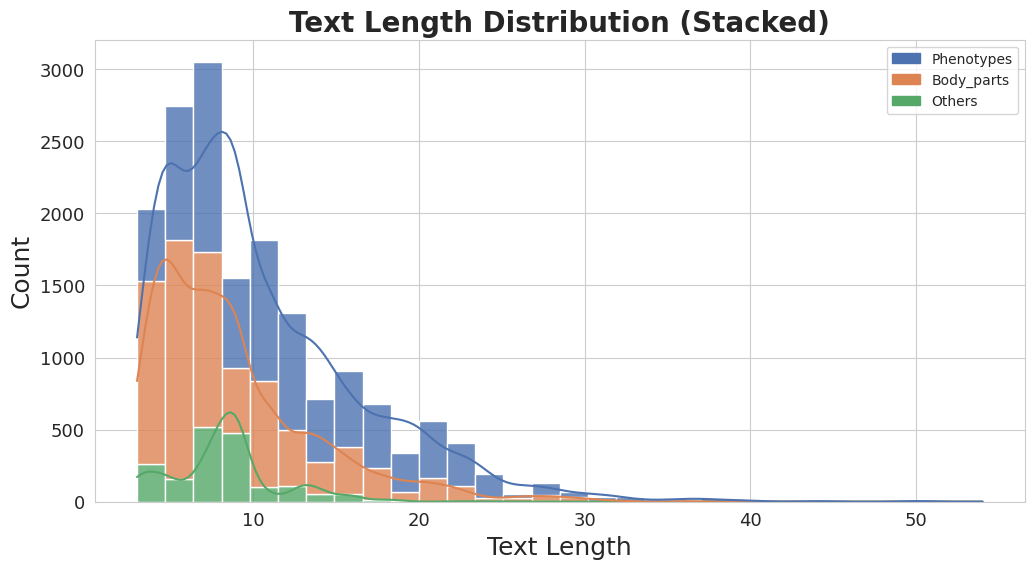

In [14]:
# Calculate text length (number of characters)
annotations['text_length'] = annotations['text'].apply(len)

# Create a seaborn histogram, or "distplot"
sns.set_style("whitegrid") 
plt.figure(figsize=(12, 6))  

# Seaborn deep palette colors
deep_palette = sns.color_palette("deep")

# Create the histogram with seaborn's 'histplot'
sns.histplot(annotations, x='text_length', hue='class', bins=30, kde=True, alpha=0.8, palette='deep', multiple="stack")  

plt.xlabel('Text Length', fontsize=18)  # Add label for x-axis
plt.ylabel('Count', fontsize=18)  # Add label for y-axis
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(handles=legend_patches)
plt.title('Text Length Distribution (Stacked)', fontsize=20, fontweight='bold')  # Add title

plt.show()


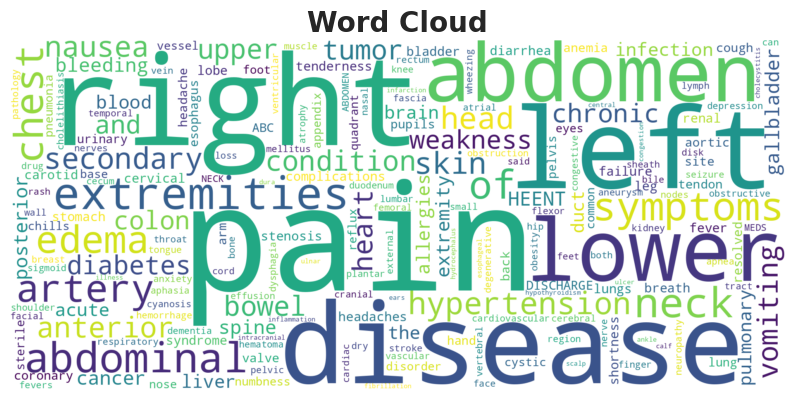

In [15]:
# Get word frequencies
word_freq = Counter(' '.join(annotations['text']).split())

# Plot word cloud
wordcloud = WordCloud(width=2000, height=900,  # Increase resolution
                      max_words=200,  # Limit the number of words
                      colormap='viridis',  # Change color palette
                      background_color='white',  # Set background color
                      normalize_plurals=True,  # Normalize plurals
                      contour_color='black',  # Set contour color
                      contour_width=1  # Set contour width
                      ).generate_from_frequencies(word_freq)

plt.figure(figsize=(10,5))  # Increase plot size
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud', fontsize=20, fontweight='bold')  # Increase title size
plt.show()

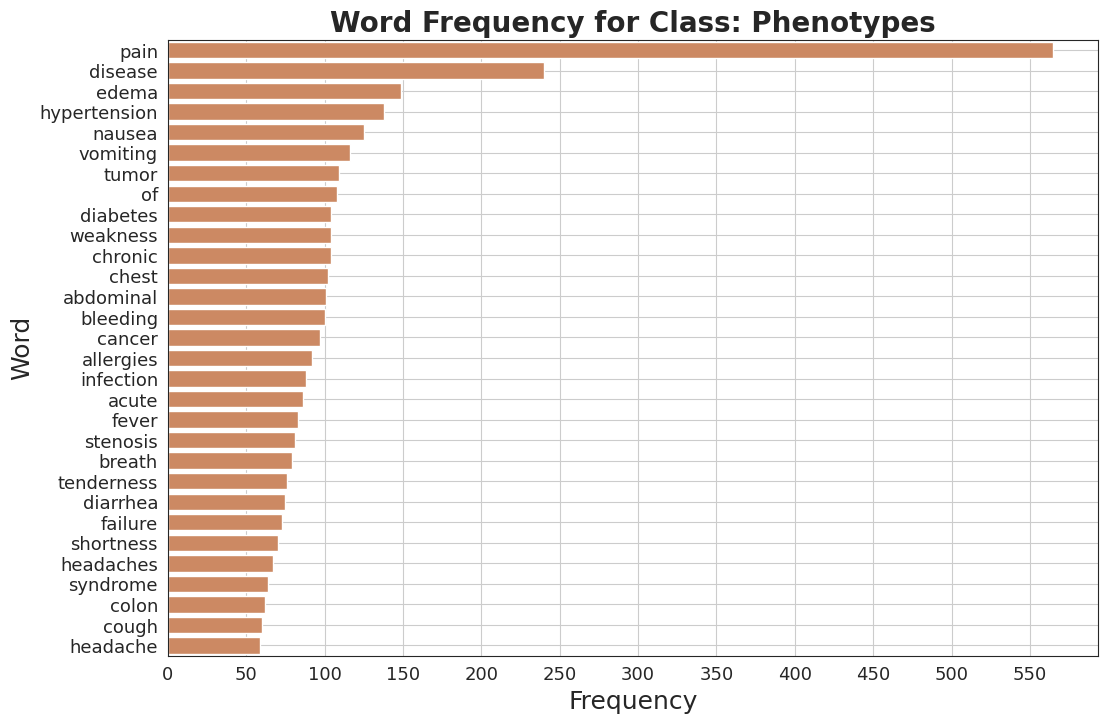

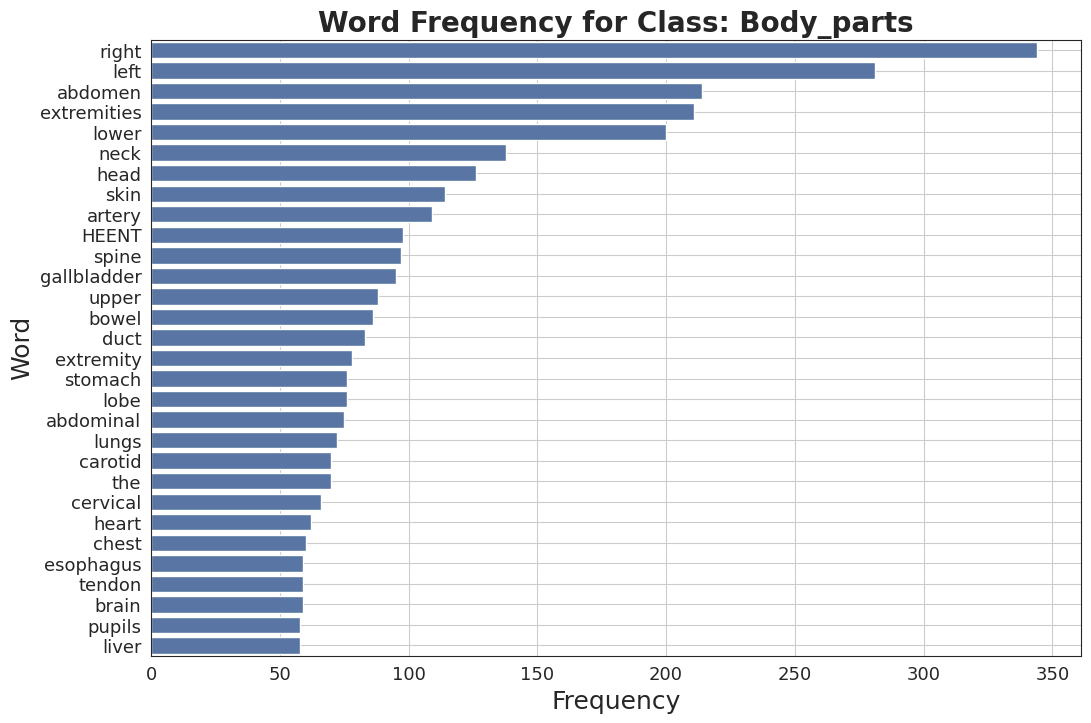

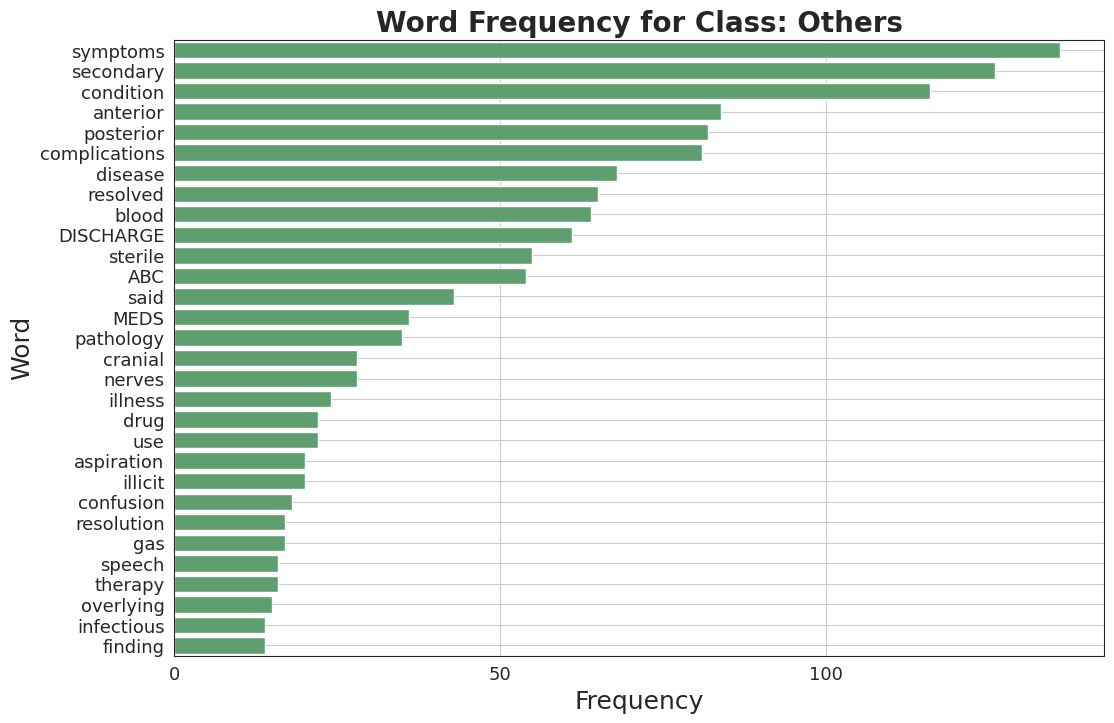

In [16]:

# Calculate word frequencies for each class
class_word_freq = {}
for class_label in annotations['class'].unique():
    class_text = ' '.join(annotations[annotations['class'] == class_label]['text'])
    tokens = class_text.split()
    freq_dist = FreqDist(tokens)
    class_word_freq[class_label] = freq_dist

# Seaborn deep palette colors
deep_palette = sns.color_palette("deep")

# Define a palette as a dictionary
palette = {'Phenotypes': deep_palette[1], 'Body_parts': deep_palette[0], 'Others': deep_palette[2]}

# Plot word frequency for each class
for class_label, freq_dist in class_word_freq.items():
    # Create a DataFrame from the frequency distribution
    df = pd.DataFrame(list(freq_dist.items()), columns=["Word", "Frequency"]).nlargest(columns="Frequency", n=30)

    # Create a seaborn barplot
    sns.set_style("white")  # Set style
    plt.figure(figsize=(12, 8))  # Set figure size
    
    # Create barplot
    sns.barplot(data=df, x='Frequency', y='Word', orient='h', color=palette[class_label])
    
    plt.xlabel('Frequency', fontsize=18)  # Add label for x-axis
    plt.ylabel('Word', fontsize=18)  # Add label for y-axis
    plt.title(f'Word Frequency for Class: {class_label}', fontsize=20, fontweight='bold')  # Add title
    
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    
    # Add grid
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(50))  # Adjust the number as needed
    ax.yaxis.set_major_locator(MultipleLocator(1))  # Adjust the number as needed
    plt.grid(True)

    plt.show()


## Word Window

In [17]:
def read_file(file_path):
    with open(file_path, 'r') as f:
        return f.read()

def add_context(df, n):
    # copy the dataframe to avoid modifying the original one
    df = df.copy()
    
    # iterate over each row
    for idx, row in df.iterrows():
        # read the file
        file_content = read_file(os.path.join("amlh_nlp_dataset_2023/docs", row['file']))
        
        # get the start and end positions
        start, end = row['start'], row['end']
        
        # split the file content into words and punctuation
        words = re.findall(r'\b\w+\b|[.,!?;]', file_content)
        
        # find the position of the start and end words
        start_word_pos = len(re.findall(r'\b\w+\b|[.,!?;]', file_content[:start]))
        end_word_pos = len(re.findall(r'\b\w+\b|[.,!?;]', file_content[:end]))
        
        # get the words before and after the annotated text
        before = words[max(0, start_word_pos-n):start_word_pos]
        after = words[end_word_pos:end_word_pos+n]
        
        # add n words to the text, if they exist
        df.at[idx, 'text'] = ' '.join(before + [row['text']] + after)
    
    return df

In [39]:
# Set 'class' to 1 if it's "Phenotypes", otherwise 0
annotations['class'] = np.where(annotations['class'] == 'Phenotypes', 1, 0)

# Apply the add_context function
annotations_context = add_context(annotations, 4)
annotations_context .head()

In [38]:
# Load the English language model
nlp = spacy.load('en_core_web_sm')

# Perform dependency parsing
parsed_sentences = []
for sentence in annotations_context['text']:
    doc = nlp(sentence)
    parsed_sentence = [(token.text, token.dep_) for token in doc]
    parsed_sentences.append(parsed_sentence)

# Print parsed sentences
for parsed_sentence in parsed_sentences:
    print(parsed_sentence)

The dependency parsing visualization (style='dep') will create a graphical representation of the sentence where words are nodes in the graph and grammatical relationships between words are the edges between these nodes.

Each word is connected to its dependents by an arrow whose label indicates the type of syntactic relationship (e.g., 'nsubj' for nominal subject, 'dobj' for direct object, etc.). The direction of the arrow shows the direction of the dependency: it points from the head (governor) to the dependent. This visualization can be very useful for understanding the syntactic structure of a sentence.

In [37]:
# Select a few examples from your dataset
examples = annotations_context.sample(3)['text'].tolist()

# Perform dependency parsing and visualize
for example in examples:
    doc = nlp(example)
    displacy.render(doc, style='dep', jupyter=True)

identifying phenotypes in clinical notes, it's plausible that the exact span could be quite important - phenotypes could potentially be described in complex ways over several tokens, and getting the full extent of the description correct might be key to proper downstream interpretation.

# BiLSTM multiple context windows

## Loading Data

In [21]:
def label_tolist(row):
    return [row['class']]

In [22]:
# Load Data
df = pd.read_csv('amlh_nlp_dataset_2023/amlh_coursework_2023_manuallyannotated.csv')

# Enocode classes
df['class'] = np.where(df['class'] == 'Phenotypes', 1, 0)

In [23]:
df.head()

,Unnamed: 0,file,start,end,text,class
0,0,3241_General Medicine.txt,1820,1828,cyanosis,1
1,1,3241_General Medicine.txt,1327,1344,umbilical hernias,1
2,2,3241_General Medicine.txt,1356,1363,ascites,1
3,3,3241_General Medicine.txt,1842,1847,edema,1
4,4,3241_General Medicine.txt,1526,1534,prostate,0


In [24]:
# Create unique list of phenotype annotations from initial data load
# This will be used to update the tags after word window ias applied
phen_df = df[df['class'] == 1]
unique_values = phen_df['text'].unique()

In [25]:
# apply the function to each row
df['class'] = df.apply(label_tolist, axis=1)

In [26]:
df.head()

,Unnamed: 0,file,start,end,text,class
0,0,3241_General Medicine.txt,1820,1828,cyanosis,[1]
1,1,3241_General Medicine.txt,1327,1344,umbilical hernias,[1]
2,2,3241_General Medicine.txt,1356,1363,ascites,[1]
3,3,3241_General Medicine.txt,1842,1847,edema,[1]
4,4,3241_General Medicine.txt,1526,1534,prostate,[0]


## Helper Functions

In [27]:
def label_sequence(row):
    words = row['text'].split()
    return [row['class']] * len(words)

def label_tolist(row):
    return [row['class']]

def read_file(file_path):
    with open(file_path, 'r') as f:
        return f.read()

def add_context(df, n):
    # copy the dataframe to avoid modifying the original one
    df = df.copy()
    
    # iterate over each row
    for idx, row in df.iterrows():
        # read the file
        file_content = read_file(os.path.join("amlh_nlp_dataset_2023/docs", row['file']))
        
        # get the start and end positions
        start, end = row['start'], row['end']
        
        
        # split the file content into words only, excluding punctuation
        words = re.findall(r'\b\w+\b', file_content)
        
        # find the position of the start and end words
        start_word_pos = len(re.findall(r'\b\w+\b', file_content[:start]))
        end_word_pos = len(re.findall(r'\b\w+\b', file_content[:end]))
        
        
        # get the words before and after the annotated text
        before = words[max(0, start_word_pos-n):start_word_pos]
        after = words[end_word_pos:end_word_pos+n]
        
        # add n words to the text, if they exist
        df.at[idx, 'text'] = ' '.join(before + [row['text']] + after)

        # calculate the number of additional words
        n_before = len(before)
        n_after = len(after)

        # update the 'class_sequence' column
        df.at[idx, 'class'] = [0]*n_before + row['class'] + [0]*n_after
        
        df = df[['text', 'class']]
    
    return df

def update_tags_lstm(row):
    words = row['text'].split()
    try:
        return [1 if word in unique_values else 0 for word, tag in zip(words, row['class'])]
    except TypeError as e:
        print(f"Error: {e}")
        print(f"Problematic row: {row}")
        return None  

In [28]:
nlp = spacy.load('en_core_web_sm')

def preprocess_data(df):
    
    df['class'] = df['class'].apply(lambda x: [int(i) for i in x])

    # Split Data into train, validation and test set
    train_df, val_df, test_df = np.split(df.sample(frac=1, random_state=42), [int(.8 * len(df)), int(.9 * len(df))])

    # Tokenize with SpaCy
    train_texts = train_df['text'].apply(lambda x: [token.text for token in nlp(x)])
    val_texts = val_df['text'].apply(lambda x: [token.text for token in nlp(x)])
    test_texts = test_df['text'].apply(lambda x: [token.text for token in nlp(x)])

    tokenizer = Tokenizer(oov_token="<UNK>")
    tokenizer.fit_on_texts(train_texts)

    word_index = tokenizer.word_index
    word2id = word_index
    # dict. that map each identifier to its word
    id2word = {}
    for key, value in word2id.items():
        id2word[value] = key

    # Converting text data to sequences for all sets
    train_sequences = tokenizer.texts_to_sequences(train_texts)
    val_sequences = tokenizer.texts_to_sequences(val_texts)
    test_sequences = tokenizer.texts_to_sequences(test_texts)

    # Padding sequences
    max_len = max([len(seq) for seq in train_sequences])

    train_padded_sequences = pad_sequences(train_sequences, maxlen=max_len)
    val_padded_sequences = pad_sequences(val_sequences, maxlen=max_len)
    test_padded_sequences = pad_sequences(test_sequences, maxlen=max_len)

    # Prepare labels
    train_tags = train_df['class'].values
    val_tags = val_df['class'].values
    test_tags = test_df['class'].values

    # Padding labels
    train_padded_tags = pad_sequences(train_tags, maxlen=max_len)
    val_padded_tags = pad_sequences(val_tags, maxlen=max_len)
    test_padded_tags = pad_sequences(test_tags, maxlen=max_len)

    # One-hot encoding of labels
    train_labels = to_categorical(train_padded_tags, num_classes=2)
    val_labels = to_categorical(val_padded_tags, num_classes=2)
    test_labels = to_categorical(test_padded_tags, num_classes=2)

    # Convert to tf.data.Dataset
    train_dataset = tf.data.Dataset.from_tensor_slices((train_padded_sequences, train_labels))
    val_dataset = tf.data.Dataset.from_tensor_slices((val_padded_sequences, val_labels))
    test_dataset = tf.data.Dataset.from_tensor_slices((test_padded_sequences, test_labels))

    # Shuffle and batch the datasets
    buffer_size = 10000 # adjust this depending on your dataset size
    batch_size = 32
    train_dataset = train_dataset.shuffle(buffer_size, seed=42).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

    return train_df, val_df, test_df, train_dataset, val_dataset, test_dataset, tokenizer, max_len, test_padded_sequences, test_sequences, test_labels, id2word 

In [29]:
def build_and_train_model(train_dataset, val_dataset, tokenizer, max_len):
    def build_model(hp):
        model = Sequential([
            Embedding(input_dim=len(tokenizer.word_index)+1, 
                      output_dim=hp.Int('output_dim', min_value=32, max_value=256, step=32), 
                      input_length=max_len),
            Bidirectional(LSTM(units=hp.Int('units', min_value=32, max_value=256, step=32), return_sequences=True)),
            Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)),
            TimeDistributed(Dense(2, activation='softmax'))  
        ])

        model.compile(loss='binary_crossentropy', 
                      optimizer=Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])), 
                      metrics=['accuracy'])
        return model

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Add ModelCheckpoint
    model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

    tuner = BayesianOptimization(
        build_model,
        objective='val_loss',
        max_trials=5, 
        seed=42,
        executions_per_trial=1,
        directory='tuner_results',
        project_name='NER_tuning',
        overwrite=True
    )

    num_epochs = 30

    tuner.search(train_dataset, 
                 epochs=num_epochs, 
                 validation_data=val_dataset, 
                 callbacks=[early_stop, model_checkpoint])  # Add model_checkpoint here
    
    # Get the optimal hyperparameters
    best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

    # Building the model with the optimal hyperparameters
    model = tuner.hypermodel.build(best_hps)
    
    # Save the initial weights
    model.save_weights('initial_weights.h5')

    # Load the initial weights before training
    model.load_weights('initial_weights.h5')

    # Fit model
    history = model.fit(train_dataset, 
                        epochs=num_epochs, 
                        validation_data=val_dataset, 
                        callbacks=[early_stop, model_checkpoint],  # And here
                        verbose=2)

    return model, best_hps, history


In [30]:
# Convert the sequence of predicted indices to labels
def pred2label(pred):
    # Create a dictionary to map index-to-label.
    idx2tag = {0: 0, 1: 1}
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out

# Do the same for the true labels
def true2label(true):
    # Create a dictionary to map index-to-label.
    idx2tag = {0: 0, 1: 1}
    out = []
    for true_i in true:
        out_i = []
        for t in true_i:
            out_i.append(idx2tag[np.argmax(t)])
        out.append(out_i)
    return out

In [31]:
# Function to convert int to str labels
def int_to_str_labels(labels):
    str_labels = []
    for seq in labels:
        str_seq = ['B-PHEN' if label == 1 else 'O' for label in seq]
        str_labels.append(str_seq)
    return str_labels

In [32]:
# Convert a sequence of word indices back to words
def indices_to_words(id2word, sequence):
    return [id2word[index] if index in id2word else "<UNK>" for index in sequence]

# Convert a sequence of label indices back to labels
def indices_to_labels(sequence):
    return [ 1 if label == 1 else 0 for label in sequence]


In [33]:
# Function to evaluate a given model
def evaluate_model(model, test_padded_sequences, test_labels, model_name):
    
    test_pred = model.predict(test_padded_sequences)
    pred_labels = pred2label(test_pred)
    test_labels = true2label(test_labels)
    
    # Convert pred_labels and test_labels
    pred_str_labels = int_to_str_labels(pred_labels)
    test_str_labels = int_to_str_labels(test_labels)

    # Calculate precision, recall, f1 score
    precision = precision_score(test_str_labels, pred_str_labels)
    recall = recall_score(test_str_labels, pred_str_labels)
    f1 = f1_score(test_str_labels, pred_str_labels)
    
    model_metrics = {"precision": precision, "recall": recall, "f1_score": f1}
    
    # Convert the dictionary to a DataFrame
    df_metrics = pd.DataFrame([model_metrics], columns=model_metrics.keys())
    
    # Add the model name as a new column 'Model'
    df_metrics['Model'] = model_name

    # Reorder the columns to have 'Model' as the first column
    df_metrics = df_metrics[['Model', 'precision', 'recall', 'f1_score']]

    # Return as a DataFrame
    return df_metrics

## Run Pipeline for Multiple Context Windows

In [36]:
context_windows = [3, 4, 5, 6]  # window sizes
results = pd.DataFrame()  # empty DataFrame to store the results
best_hps_per_model = {}  # Dictionary to store the best hyperparameters per model
history_per_model = {}  # Dictionary to store the history per model
trained_models = {}  # Dictionary to store the trained models
test_data_per_model = {}  # Dictionary to store test_padded_sequences per model
test_labels_per_model = {}  # Dictionary to store test_labels per model
id2word_per_model = {}      # Dictionary to store id2words per model
tokenizer_per_model = {}    # Dictionary to store tokenizer per model
df_window_per_model = {}    # Dictionary to store df window per model
max_len_per_model = {}      # Dictionary to store max_len per model

for n in context_windows:
    
    model_name = f"BiLSTM_Model_{n}_Context"
    
    # Add context to the data
    df_with_context = add_context(df, n)
    
    # Update tag names for words added from word window
    df_with_context['class'] = df_with_context.apply(update_tags_lstm, axis=1)
    
    # Save dataframe
    df_window_per_model[model_name] = df_with_context

    # Split and tokenize the data
    train_df, val_df, test_df, train_dataset, val_dataset, test_dataset, tokenizer, max_len, test_padded_sequences, test_sequences, test_labels, id2word = preprocess_data(df_with_context)
    test_data_per_model[model_name] = test_padded_sequences
    test_labels_per_model[model_name] = test_labels
    id2word_per_model[model_name] =  id2word
    tokenizer_per_model[model_name] = tokenizer
    max_len_per_model[model_name] = max_len
    
    # Build, tune, and train the model, and save the best hyperparameters, the history, and the trained model
    model, best_hps, history = build_and_train_model(train_dataset, val_dataset, tokenizer, max_len)
    best_hps_per_model[model_name] = best_hps
    history_per_model[model_name] = history
    trained_models[model_name] = model

    # Evaluate the model on the test data and append the results to the results DataFrame
    df_metrics = evaluate_model(model, test_padded_sequences, test_labels, model_name)
    results = pd.concat([results, df_metrics], ignore_index=True)



Reproducibility in deep learning is a complex issue and setting these seeds does not guarantee complete reproducibility. For example, inconsistencies can still occur when running on GPUs due to the asynchronous nature of GPU computations.

For the Keras models, you may also want to initialize the model's weights in a deterministic way before training. Unfortunately, this isn't straightforward in Keras. One workaround is to save the model's weights after initialization and load them every time before training. Here's how:

In [100]:
results

# Results - Best Model

In [114]:
history = history_per_model['BiLSTM_Model_3_Context']

In [115]:
# Create a dictionary to map index-to-label.
idx2tag = {0: 0, 1: 1}

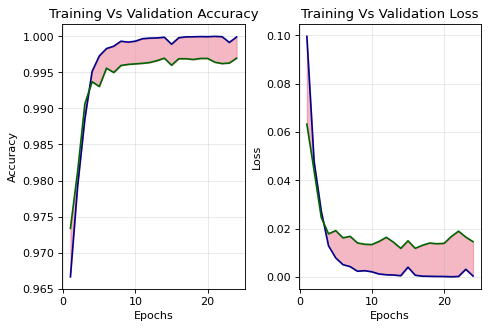

In [116]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(6, 4), dpi=80)

ax[0].plot(epochs, acc, label = "Training Accuracy", color='darkblue')
ax[0].plot(epochs, val_acc, label = "Validation Accuracy", color='darkgreen')
ax[0].grid(alpha=0.3)
ax[0].title.set_text('Training Vs Validation Accuracy')
ax[0].fill_between(epochs, acc, val_acc, color='crimson', alpha=0.3)
plt.setp(ax[0], xlabel='Epochs')
plt.setp(ax[0], ylabel='Accuracy')


ax[1].plot(epochs, loss, label = "Training Loss", color='darkblue')
ax[1].plot(epochs, val_loss, label = "Validation Loss", color='darkgreen')
ax[1].grid(alpha=0.3)
ax[1].title.set_text('Training Vs Validation Loss')
ax[1].fill_between(epochs,loss, val_loss, color='crimson', alpha=0.3)
plt.setp(ax[1], xlabel='Epochs')
plt.setp(ax[1], ylabel='Loss')

plt.show()

### Test Data Predictions

* Use dictionary of result outputs to change this to the best model and then inspect results.
* Maybe different accuracy/loss vs epoch graphs can be shown?

In [118]:
# Create variables for most performant model as per df_metrics table
model = trained_models['BiLSTM_Model_3_Context']
test_padded_sequences = test_data_per_model['BiLSTM_Model_3_Context']
test_labels = test_labels_per_model['BiLSTM_Model_3_Context']
id2word = id2word_per_model['BiLSTM_Model_3_Context']

In [98]:
# Predictions & lables
test_pred = model.predict(test_padded_sequences)
pred_labels = pred2label(test_pred)
test_labels = true2label(test_labels)

In [99]:
# Pick a random example from the test set
i = random.randint(0, len(test_padded_sequences)-1)

# Convert the word indices to words
words = indices_to_words(id2word, test_padded_sequences[i])

# Convert the label indices to labels
true_labels = indices_to_labels(test_labels[i])

# Get the predicted labels
predicted_labels = indices_to_labels(np.argmax(model.predict(test_padded_sequences[i:i+1])[0], axis=-1))

# Print them out
print("{:15} {:5} {}".format("Word", "True", "Pred"))
print("="*30)
for w, t, p in zip(words, true_labels, predicted_labels):
    print("{:15} {:3} {:5}".format(w, t, p))

In [121]:
# Generate predictions on the full test dataset
test_pred = np.argmax(test_pred, axis=-1)

# Initialize lists to hold data
sequence_indices = []
words_list = []
true_labels_list = []
pred_labels_list = []

# Iterate over the test data and the predictions
for i, (seq, true_labels, pred_labels) in enumerate(zip(test_padded_sequences, test_labels, test_pred)):
    # Convert the sequences of indices back to words and labels
    words = indices_to_words(id2word, seq)
    true_labels = indices_to_labels(true_labels)
    pred_labels = indices_to_labels(pred_labels)

    # Add the sequence index, words and labels to the lists
    sequence_indices.extend([i]*len(words))
    words_list.extend(words)
    true_labels_list.extend(true_labels)
    pred_labels_list.extend(pred_labels)

# Create a DataFrame from the lists
df_seq = pd.DataFrame({
    'Sequence Index': sequence_indices,
    'Words': words_list,
    'True Labels': true_labels_list,
    'Predicted Labels': pred_labels_list
})

### Grouping Sequences

In [97]:
df_seq.tail(11)

Here we group those sequences where the model found more phenotype mentions compared to the baseline annotations.

In [95]:
# group  dataframe by 'Sequence Index' and sum the 'True Labels' and 'Predicted Labels' for each group
grouped_df = df_seq.groupby('Sequence Index').sum()

# filter the groups where the sum of 'Predicted Labels' is greater than the sum of 'True Labels':
more_preds = grouped_df[grouped_df['Predicted Labels'] > grouped_df['True Labels']]

# create the desired dataframe by filtering the original dataframe using the sequence IDs from more_preds:
filtered_df = df_seq[df_seq['Sequence Index'].isin(more_preds.index)]

In [96]:
# Inspect Sequences
filtered_df['Sequence Index'].unique()

In the below output, 'diarrhea' has been identified as a phenotype where this was not labelled in the extended word window text. The manually annotated data only labelled 'vomiting' as the phenotype, therefore the LSTM model was able to pick out new phenotypes in the text added during the word window.

It is probably worth repeating this problem with 3 classes, phenotype, non-phenotype and other in future work to see how the model behaves as this binary classification problem does not capture all the information in the context of this sentence.

In [93]:
filtered_df[filtered_df['Sequence Index'] ==  1387]

In [94]:
for idx in filtered_df['Sequence Index'].unique():
    print(filtered_df[filtered_df['Sequence Index'] == idx])

### DisplaCy

In [127]:

def create_docs(df, seq_index):
    nlp = spacy.blank('en')  # load a new spacy model
    
    # Retrieve the sequence from the DataFrame
    df_sequence = df[df['Sequence Index'] == seq_index]
    
    # Combine the words back into a sentence
    text = ' '.join(df_sequence['Words'].values)
    
    # Create an nlp object for doc
    doc = nlp(text)
    
    # Get the predicted labels for this sequence
    predicted_labels = df_sequence['Predicted Labels'].values
    
    # Compute the actual sequence length
    sequence_length = len(doc)
    
    # Manually set the entities using the labels predicted by your model
    entities = [Span(doc, start=sequence_length - i - 1, end=sequence_length - i, label='PHENOTYPE') for i, label in enumerate(predicted_labels[::-1]) if label == 1]
    
    # Set the entities for doc
    doc.ents = entities
    
    # Create an nlp object for doc_true
    doc_true = nlp(text)
    
    # Get the true labels for this sequence
    true_labels = df_sequence['True Labels'].values
    
    # Manually set the entities using the true labels
    entities_true = [Span(doc_true, start=sequence_length - i - 1, end=sequence_length - i, label='PHENOTYPE') for i, label in enumerate(true_labels[::-1]) if label == 1]

    doc_true.ents = entities_true
    
    return doc, doc_true

Comparing predicted tags to original test tag.

In [129]:
# Usage example
seq_index = 253 # change this to your chosen sequence index 
doc, doc_true = create_docs(df_seq, seq_index)

# Visualize the predicted entities
print('Predicted entities:')
displacy.render(doc, style='ent', jupyter=True)

# Visualize the true entities
print('True entities:')
displacy.render(doc_true, style='ent', jupyter=True)


Predicted entities:


True entities:


In [130]:
df_with_context = df_window_per_model['BiLSTM_Model_3_Context']

In [135]:
# Function to apply model to test string and determine phenotype tags
def tag_string(string, model, tokenizer, max_len, id2word):
    # Tokenize string
    tokens = [token.text for token in nlp(string)]

    # Convert tokens to sequences
    sequences = tokenizer.texts_to_sequences([tokens])

    # Pad sequences
    padded_sequences = pad_sequences(sequences, maxlen=max_len)

    # Predict tags
    predictions = model.predict(padded_sequences)

    # Convert predictions into tags
    predicted_tags = pred2label(predictions[0])

    # Convert sequence of word indices back to words
    words = indices_to_words(id2word, sequences[0])

    # Zip together words and predicted tags
    tagged_string = list(zip(words, predicted_tags))

    return tagged_string

In [136]:
string = '''onset of symptoms started 3 days ago with a dry cough. He also noticed a low-grade fever'''

In [137]:
model_lstm_3 = trained_models["BiLSTM_Model_3_Context"]
tokentizer_lstm_3 = tokenizer_per_model["BiLSTM_Model_3_Context"]
id2word_lstm_3= id2word_per_model["BiLSTM_Model_3_Context"]
max_len_lstm_3 = max_len_per_model['BiLSTM_Model_3_Context']

In [37]:
tagged_string = tag_string(string, model_lstm_3, tokentizer_lstm_3, max_len_lstm_3, id2word_lstm_3)

## LSTM_Model_5_Context

The LSTM_Model_5_Context is inspected as this model potentially has more phenotype mentions given its lower precision (i.e. more false positives).

In [143]:
# Create variables for most performant model as per df_metrics table
model_5 = trained_models['BiLSTM_Model_5_Context']
test_padded_sequences_5 = test_data_per_model['BiLSTM_Model_5_Context']
test_labels_5 = test_labels_per_model['BiLSTM_Model_5_Context']
id2word_5 = id2word_per_model['BiLSTM_Model_5_Context']

In [144]:
# Predictions & lables
test_pred_5 = model_5.predict(test_padded_sequences_5)
pred_labels_5 = pred2label(test_pred_5)
test_labels_5 = true2label(test_labels_5)

53/53 [==============================] - 0s 2ms/step


In [38]:
# Pick a random example from the test set
i = random.randint(0, len(test_padded_sequences_5)-1)

# Convert the word indices to words
words_5 = indices_to_words(id2word_5, test_padded_sequences_5[i])

# Convert the label indices to labels
true_labels_5 = indices_to_labels(test_labels_5[i])

# Get the predicted labels
predicted_labels_5 = indices_to_labels(np.argmax(model_5.predict(test_padded_sequences_5[i:i+1])[0], axis=-1))

# Print them out
print("{:15} {:5} {}".format("Word", "True", "Pred"))
print("="*30)
for w, t, p in zip(words_5, true_labels_5, predicted_labels_5):
    print("{:15} {:3} {:5}".format(w, t, p))

In [146]:
# Generate predictions on the full test dataset
test_pred_5 = np.argmax(test_pred_5, axis=-1)

# Initialize lists to hold data
sequence_indices_5 = []
words_list_5 = []
true_labels_list_5 = []
pred_labels_list_5 = []

# Iterate over the test data and the predictions
for i, (seq, true_labels, pred_labels) in enumerate(zip(test_padded_sequences_5, test_labels_5, test_pred_5)):
    # Convert the sequences of indices back to words and labels
    words = indices_to_words(id2word, seq)
    true_labels = indices_to_labels(true_labels)
    pred_labels = indices_to_labels(pred_labels)

    # Add the sequence index, words and labels to the lists
    sequence_indices_5.extend([i]*len(words))
    words_list_5.extend(words)
    true_labels_list_5.extend(true_labels)
    pred_labels_list_5.extend(pred_labels)

# Create a DataFrame from the lists
df_seq_5 = pd.DataFrame({
    'Sequence Index': sequence_indices_5,
    'Words': words_list_5,
    'True Labels': true_labels_list_5,
    'Predicted Labels': pred_labels_list_5
})

### Grouping Sequences

In [46]:
# group  dataframe by 'Sequence Index' and sum the 'True Labels' and 'Predicted Labels' for each group
grouped_df_5 = df_seq_5.groupby('Sequence Index').sum()

# filter the groups where the sum of 'Predicted Labels' is greater than the sum of 'True Labels':
more_preds_5 = grouped_df_5[grouped_df_5['Predicted Labels'] > grouped_df_5['True Labels']]

# create the desired dataframe by filtering the original dataframe using the sequence IDs from more_preds:
filtered_df_5 = df_seq_5[df_seq_5['Sequence Index'].isin(more_preds_5.index)]

In [39]:
# Inspect Sequences
filtered_df_5['Sequence Index'].unique()

In [42]:
filtered_df_5[filtered_df_5['Sequence Index'] ==  1577]

A lot of false positives due to incorrect annotations before and after applying the new tags to the data.

In [43]:
for idx in filtered_df_5['Sequence Index'].unique():
    print(filtered_df_5[filtered_df_5['Sequence Index'] == idx])

### DisplaCy

In [44]:
# Usage example
seq_index = 843 # change this to your chosen sequence index 
doc_5, doc_true_5 = create_docs(df_seq_5, seq_index)

# Visualize the predicted entities
print('Predicted entities:')
displacy.render(doc_5, style='ent', jupyter=True)

# Visualize the true entities
print('True entities:')
displacy.render(doc_true_5, style='ent', jupyter=True)

In [159]:
df_with_context_5 = df_window_per_model['BiLSTM_Model_5_Context']

In [160]:
model_lstm_5 = trained_models["BiLSTM_Model_5_Context"]
tokentizer_lstm_5 = tokenizer_per_model["BiLSTM_Model_5_Context"]
id2word_lstm_5 = id2word_per_model["BiLSTM_Model_5_Context"]
max_len_lstm_5 = max_len_per_model['BiLSTM_Model_5_Context']

Model struggles to find phenotypes.

In [45]:
tagged_string_5 = tag_string(string, model_lstm_5, tokentizer_lstm_5, max_len_lstm_5, id2word_lstm_5)

# LSTM

In [190]:
def build_and_train_model_without_dropout(train_dataset, val_dataset, tokenizer, max_len):
    def build_model(hp):
        model = Sequential([
            Embedding(input_dim=len(tokenizer.word_index)+1, 
                      output_dim=hp.Int('output_dim', min_value=32, max_value=256, step=32), 
                      input_length=max_len),
            LSTM(units=hp.Int('units', min_value=32, max_value=256, step=32), return_sequences=True),
            Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)),
            TimeDistributed(Dense(2, activation='softmax'))  
        ])

        model.compile(loss='categorical_crossentropy', 
                      optimizer=Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])), 
                      metrics=['accuracy'])
        return model

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Add ModelCheckpoint
    model_checkpoint = ModelCheckpoint('best_model_no_dropout.h5', monitor='val_loss', save_best_only=True)

    tuner = BayesianOptimization(
        build_model,
        objective='val_loss',
        max_trials=5,  # set this to a higher value for a larger search space
        seed=42,
        executions_per_trial=1,
        directory='tuner_results',
        project_name='NER_tuning_no_dropout',
        overwrite=True
    )

    num_epochs = 30

    tuner.search(train_dataset, 
                 epochs=num_epochs, 
                 validation_data=val_dataset, 
                 callbacks=[early_stop, model_checkpoint])  # Add model_checkpoint here
    
    # Get the optimal hyperparameters
    best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

    # Building the model with the optimal hyperparameters
    model = tuner.hypermodel.build(best_hps)
    
    # Save the initial weights
    model.save_weights('initial_weights_no_dropout.h5')

    # Load the initial weights before training
    model.load_weights('initial_weights_no_dropout.h5')

    # Fit model
    history = model.fit(train_dataset, 
                        epochs=num_epochs, 
                        validation_data=val_dataset, 
                        callbacks=[early_stop, model_checkpoint],  # And here
                        verbose=2)

    return model, best_hps, history

In [46]:
context_windows = [3, 4, 5,6] # window sizes
best_hps_per_model = {}  # Dictionary to store the best hyperparameters per model
history_per_model = {}  # Dictionary to store the history per model
trained_models = {}  # Dictionary to store the trained models
test_data_per_model = {}  # Dictionary to store test_padded_sequences per model
test_labels_per_model = {}  # Dictionary to store test_labels per model
id2word_per_model = {}      # Dictionary to store id2words per model
tokenizer_per_model = {}    # Dictionary to store tokenizer per model
df_window_per_model = {}    # Dictionary to store df window per model
max_len_per_model = {}      # Dictionary to store max_len per model
            

for n in context_windows:
    
    model_name = f"LSTM_Model_{n}_Context"
    
    # Add context to the data
    df_with_context = add_context(df, n)
    
    # Update tag names for words added from word window
    df_with_context['class'] = df_with_context.apply(update_tags_lstm, axis=1)
    
    # Save dataframe
    df_window_per_model[model_name] = df_with_context

    # Split and tokenize the data
    train_df, val_df, test_df, train_dataset, val_dataset, test_dataset, tokenizer, max_len, test_padded_sequences, test_sequences, test_labels, id2word = preprocess_data(df_with_context)
    test_data_per_model[model_name] = test_padded_sequences
    test_labels_per_model[model_name] = test_labels
    id2word_per_model[model_name] =  id2word
    tokenizer_per_model[model_name] = tokenizer
    max_len_per_model[model_name] = max_len
    
    # Build, tune, and train the model, and save the best hyperparameters, the history, and the trained model
    model, best_hps, history = build_and_train_model_without_dropout(train_dataset, val_dataset, tokenizer, max_len)
    best_hps_per_model[model_name] = best_hps
    history_per_model[model_name] = history
    trained_models[model_name] = model

    # Evaluate the model on the test data and append the results to the results DataFrame
    df_metrics = evaluate_model(model, test_padded_sequences, test_labels, model_name)
    results = pd.concat([results, df_metrics], ignore_index=True)

In [194]:
history_abl = history_per_model['LSTM_Model_3_Context']

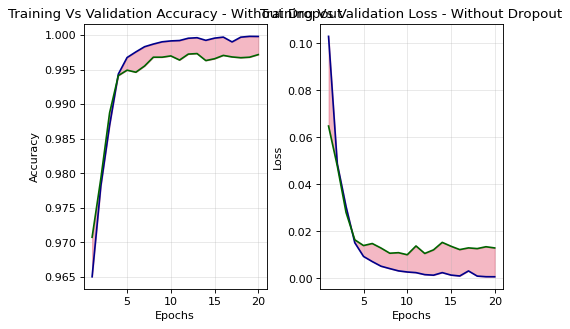

In [195]:
acc = history_abl.history['accuracy']
val_acc = history_abl.history['val_accuracy']

loss = history_abl.history['loss']
val_loss = history_abl.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(6, 4), dpi=80)

ax[0].plot(epochs, acc, label = "Training Accuracy", color='darkblue')
ax[0].plot(epochs, val_acc, label = "Validation Accuracy", color='darkgreen')
ax[0].grid(alpha=0.3)
ax[0].title.set_text('Training Vs Validation Accuracy - Without Dropout')
ax[0].fill_between(epochs, acc, val_acc, color='crimson', alpha=0.3)
plt.setp(ax[0], xlabel='Epochs')
plt.setp(ax[0], ylabel='Accuracy')


ax[1].plot(epochs, loss, label = "Training Loss", color='darkblue')
ax[1].plot(epochs, val_loss, label = "Validation Loss", color='darkgreen')
ax[1].grid(alpha=0.3)
ax[1].title.set_text('Training Vs Validation Loss - Without Dropout')
ax[1].fill_between(epochs,loss, val_loss, color='crimson', alpha=0.3)
plt.setp(ax[1], xlabel='Epochs')
plt.setp(ax[1], ylabel='Loss')

plt.show()

# BERT - Context Window

In [63]:
def label_sequence(row):
    words = row['text'].split()
    return [row['class']] * len(words)

In [64]:
def update_tags(row):
    words = row['text'].split()
    try:
        return ['PHEN' if word in unique_values else tag for word, tag in zip(words, row['class'])]
    except TypeError as e:
        print(f"Error: {e}")
        print(f"Problematic row: {row}")
        return None  

In [65]:
def read_file(file_path):
    with open(file_path, 'r') as f:
        return f.read()
    
def add_window(df, n):
    # copy the dataframe to avoid modifying the original one
    df = df.copy()
    
    # iterate over each row
    for idx, row in df.iterrows():
        # read the file
        file_content = read_file(os.path.join("amlh_nlp_dataset_2023/docs", row['file']))
        
        # get the start and end positions
        start, end = row['start'], row['end']
        
        # split the file content into words only, excluding punctuation
        words = re.findall(r'\b\w+\b', file_content)
        
        # find the position of the start and end words
        start_word_pos = len(re.findall(r'\b\w+\b', file_content[:start]))
        end_word_pos = len(re.findall(r'\b\w+\b', file_content[:end]))
        
        # get the words before and after the annotated text
        before = words[max(0, start_word_pos-n):start_word_pos]
        after = words[end_word_pos:end_word_pos+n]
        
        # add n words to the text, if they exist
        df.at[idx, 'text'] = ' '.join(before + [row['text']] + after)
        
        # calculate the number of additional words
        n_before = len(before)
        n_after = len(after)

        # split the 'class' into words and create a list of classes
        class_list = [row['class']] * len(row['text'].split())

        # update the 'class' column
        df.at[idx, 'class'] = ['O']*n_before + class_list + ['O']*n_after
    
    return df[['text', 'class']]

In [66]:
def align_label(texts, labels):
    
    tokenized_inputs = tokenizer(texts, padding='max_length', max_length=128, truncation=True)

    word_ids = tokenized_inputs.word_ids()

    previous_word_idx = None
    label_ids = []

    for word_idx in word_ids:

        if word_idx is None:
            label_ids.append(-100)

        elif word_idx != previous_word_idx:
            try:
                label_ids.append(labels_to_ids[labels[word_idx]])
            except:
                label_ids.append(-100)
        else:
            try:
                label_ids.append(labels_to_ids[labels[word_idx]] if label_all_tokens else -100)
            except:
                label_ids.append(-100)
        previous_word_idx = word_idx

    return label_ids

In [67]:
class DataSequence(torch.utils.data.Dataset):

    def __init__(self, df):
        lb = [i for i in df['class'].values.tolist()]
        txt = df['text'].values.tolist()
        self.texts = [tokenizer(str(i),
                               padding='max_length', max_length = 128, truncation=True, return_tensors="pt") for i in txt]
        self.labels = [align_label(i,j) for i,j in zip(txt, lb)]

    def __len__(self):

        return len(self.labels)

    def get_batch_data(self, idx):

        return self.texts[idx]

    def get_batch_labels(self, idx):

        return torch.LongTensor(self.labels[idx])

    def __getitem__(self, idx):

        batch_data = self.get_batch_data(idx)
        batch_labels = self.get_batch_labels(idx)

        return batch_data, batch_labels

In [68]:
class BertModel(torch.nn.Module):

    def __init__(self):

        super(BertModel, self).__init__()

        self.bert = BertForTokenClassification.from_pretrained('bert-base-cased', num_labels=len(unique_labels), output_attentions=True)

    def forward(self, input_id, mask, label):

        output = self.bert(input_ids=input_id, attention_mask=mask, labels=label, return_dict=True)

        return output

In [69]:
def train_loop(model, df_train, df_val, patience=5):
    
    train_dataset = DataSequence(df_train)
    val_dataset = DataSequence(df_val)

    train_dataloader = DataLoader(train_dataset, num_workers=4, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = DataLoader(val_dataset, num_workers=4, batch_size=BATCH_SIZE)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
    
    if use_cuda: 
        model = model.cuda()

    best_acc = 0
    best_loss = 1000

    # Create dictionaries to store the training and validation loss and accuracy
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    # Add early stopping variables
    num_epochs_no_improvement = 0
    early_stop = False

    for epoch_num in range(EPOCHS):

        # Early stopping
        if num_epochs_no_improvement == patience:
            print("Early stopping triggered after {} epochs with no improvement.".format(patience))
            early_stop = True
            break

        total_acc_train = 0
        total_loss_train = 0

        model.train()

        for train_data, train_label in tqdm(train_dataloader):

            train_label = train_label.to(device)
            mask = train_data['attention_mask'].squeeze(1).to(device)
            input_id = train_data['input_ids'].squeeze(1).to(device)

            optimizer.zero_grad()
            output = model(input_id, mask, train_label)
            loss = output.loss
            logits = output.logits

            for i in range(logits.shape[0]):

                logits_clean = logits[i][train_label[i] != -100]
                label_clean = train_label[i][train_label[i] != -100]

                predictions = logits_clean.argmax(dim=1)
                acc = (predictions == label_clean).float().mean()
                total_acc_train += acc
                total_loss_train += loss.item()

            loss.backward()
            optimizer.step()

        model.eval()

        total_acc_val = 0
        total_loss_val = 0

        for val_data, val_label in val_dataloader:

            val_label = val_label.to(device)
            mask = val_data['attention_mask'].squeeze(1).to(device)
            input_id = val_data['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask, val_label)
            loss = output.loss
            logits = output.logits

            for i in range(logits.shape[0]):

                logits_clean = logits[i][val_label[i] != -100]
                label_clean = val_label[i][val_label[i] != -100]

                predictions = logits_clean.argmax(dim=1)
                acc = (predictions == label_clean).float().mean()
                total_acc_val += acc
                total_loss_val += loss.item()

        # Store the loss and accuracy values in the history dictionary
        history['train_loss'].append(total_loss_train / len(df_train))
        history['train_acc'].append(total_acc_train / len(df_train))
        history['val_loss'].append(total_loss_val / len(df_val))
        history['val_acc'].append(total_acc_val / len(df_val))

         # Early stopping and checkpointing
        if history['val_loss'][-1] < best_loss:
            best_loss = history['val_loss'][-1]
            num_epochs_no_improvement = 0

            # Save the model state
            torch.save({
                'epoch': epoch_num + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_loss,
            }, os.path.join('./tuner_results', 'checkpoint.pt'))
        else:
            num_epochs_no_improvement += 1
            
        print(
            f'Epochs: {epoch_num + 1} | Loss: {history["train_loss"][-1]: .3f} | Accuracy: {history["train_acc"][-1]: .3f} | Val_Loss: {history["val_loss"][-1]: .3f} | Val_Accuracy: {history["val_acc"][-1]: .3f}')

    return model, history, early_stop

LEARNING_RATE = 2e-5
EPOCHS = 5
BATCH_SIZE = 32

In [70]:
def evaluate(model, df_test, model_name):

    test_dataset = DataSequence(df_test)
    test_dataloader = DataLoader(test_dataset, num_workers=4, batch_size=1)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    total_acc_test = 0.0
    all_predictions = []
    all_true_labels = []
    
    for test_data, test_label in test_dataloader:

        test_label = test_label.to(device)
        mask = test_data['attention_mask'].squeeze(1).to(device)
        input_id = test_data['input_ids'].squeeze(1).to(device)

        output = model(input_id, mask, test_label)
        loss = output.loss
        logits = output.logits

        for i in range(logits.shape[0]):

            logits_clean = logits[i][test_label[i] != -100]
            label_clean = test_label[i][test_label[i] != -100]

            predictions = logits_clean.argmax(dim=1)
            true_labels = label_clean.tolist()
            
            predictions_str = [ids_to_labels[pred] for pred in logits_clean.argmax(dim=1).tolist()]
            true_labels_str = [ids_to_labels[label] for label in label_clean.tolist()]

            all_predictions.append(predictions_str)
            all_true_labels.append(true_labels_str)

            acc = (predictions == label_clean).float().mean()
            total_acc_test += acc

    val_accuracy = total_acc_test / len(df_test)
    
    print(f'Test Accuracy: {val_accuracy: .3f}')
    precision = precision_score(all_true_labels, all_predictions)
    recall = recall_score(all_true_labels, all_predictions)
    f1 = f1_score(all_true_labels, all_predictions)
    
    model_metrics = {"precision": precision, "recall": recall, "f1_score": f1}
    
    # Convert the dictionary to a DataFrame
    df_metrics = pd.DataFrame([model_metrics], columns=model_metrics.keys())
    
    # Add the model name as a new column 'Model'
    df_metrics['Model'] = model_name

    # Reorder the columns to have 'Model' as the first column
    df_metrics = df_metrics[['Model', 'precision', 'recall', 'f1_score']]
    
    return df_metrics

In [71]:
def align_word_ids(texts):#
    
    tokenized_inputs = tokenizer(texts, padding='max_length', max_length=512, truncation=True)

    word_ids = tokenized_inputs.word_ids()

    previous_word_idx = None
    label_ids = []

    for word_idx in word_ids:

        if word_idx is None:
            label_ids.append(-100)

        elif word_idx != previous_word_idx:
            try:
                label_ids.append(1)
            except:
                label_ids.append(-100)
        else:
            try:
                label_ids.append(1 if label_all_tokens else -100)
            except:
                label_ids.append(-100)
        previous_word_idx = word_idx

    return label_ids


def evaluate_one_text(model, sentence):


    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    text = tokenizer(sentence, padding='max_length', max_length = 512, truncation=True, return_tensors="pt")

    mask = text['attention_mask'].to(device)
    input_id = text['input_ids'].to(device)
    label_ids = torch.Tensor(align_word_ids(sentence)).unsqueeze(0).to(device)

    logits = model(input_id, mask, None)
    logits_clean = logits[0][label_ids != -100]

    predictions = logits_clean.argmax(dim=1).tolist()
    prediction_label = [ids_to_labels[i] for i in predictions]
    print(sentence)
    print(prediction_label)

## Load Data

In [ ]:
df = pd.read_csv('amlh_nlp_dataset_2023/amlh_coursework_2023_manuallyannotated.csv')
df.head()

In [ ]:
# Update tage names
df['class'] = np.where(df['class'] == 'Phenotypes', 'PHEN', 'O')
df.head()

In [32]:
# Create unique list of phenotype annotations from initial data load
# This will be used to update the tags after word window ias applied
phen_df = df[df['class'] == 'PHEN']
unique_values = phen_df['text'].unique()

In [33]:
# Add context to the data to generate labels
df_labels = add_window(df, 2)

# Split labels based on whitespace and turn them into a list
labels = [i for i in df_labels['class'].values.tolist()]

# Check how many labels are there in the dataset
unique_labels = set()

for lb in labels:
    [unique_labels.add(i) for i in lb if i not in unique_labels]

 # Map each label into its id representation and vice versa
labels_to_ids = {k: v for v, k in enumerate(sorted(unique_labels))}
ids_to_labels = {v: k for v, k in enumerate(sorted(unique_labels))}

## Window 3

In [35]:
# Load tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')

In [76]:
LEARNING_RATES = [2e-5, 5e-5]  # learning rates

# Store results
model_results = pd.DataFrame()
trained_models = {}
test_data_per_model = {} 
histories = {}

# Add context to the data
df_window = add_window(df, 3)

# Update tag names for words added from word window
df_window['class'] = df_window.apply(update_tags, axis=1)

# df_window_per_model[model_name] = df
df_train, df_val, df_test = np.split(df_window.sample(frac=1, random_state=42), [int(.8 * len(df)), int(.9 * len(df))])

for lr in LEARNING_RATES:
    LEARNING_RATE = lr
    model_name = f"BertModel_lr_{LEARNING_RATE}_window_{3}"
    print(f"Training {model_name}...")

    test_data_per_model[model_name] = df_test

    # Build, tune, and train the model, and save the best hyperparameters, the history, and the trained model
    model = BertModel()
    model, history, early_stop = train_loop(model, df_train, df_val)

    # Store the trained model and its history
    trained_models[model_name] = model
    histories[model_name] = history

    # Evaluate the model on the test data and append the results to the results DataFrame
    metrics = evaluate(model, df_test, model_name)
    model_results = model_results.append(metrics, ignore_index=True)

# Show the results
print(model_results)


## Window 4

In [75]:
# Load tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')

In [54]:
LEARNING_RATES = [2e-5, 5e-5]

# Store results
trained_models_4 = {}
test_data_per_model_4 = {}
histories_4 = {}

# Add context to the data
df_window = add_window(df, 4)

# Update tag names for words added from word window
df_window['class'] = df_window.apply(update_tags, axis=1)

# df_window_per_model[model_name] = df
df_train, df_val, df_test = np.split(df_window.sample(frac=1, random_state=42), [int(.8 * len(df)), int(.9 * len(df))])

for lr in LEARNING_RATES:
    LEARNING_RATE = lr
    model_name = f"BertModel_lr_{LEARNING_RATE}_window_{4}"
    print(f"Training {model_name}...")

    test_data_per_model_4[model_name] = df_test

    # Build, tune, and train the model, and save the best hyperparameters, the history, and the trained model
    model_4 = BertModel()
    model_4, history_4, early_stop_4 = train_loop(model, df_train, df_val)

    # Store the trained model and its history
    trained_models_4[model_name] = model_4
    histories_4[model_name] = history_4

    # Evaluate the model on the test data and append the results to the results DataFrame
    metrics_4 = evaluate(model_4, df_test, model_name)
    model_results = model_results.append(metrics_4, ignore_index=True)

# Show the results
print(model_results)


In [93]:
evaluate_one_text(model_4, 'onset of symptoms started 3 days ago with a dry cough. He also noticed a low-grade fever')

onset of symptoms started 3 days ago with a dry cough. He also noticed a low-grade fever
['O', 'O', 'O', 'O', 'O', 'PHEN', 'PHEN', 'PHEN', 'PHEN', 'PHEN', 'PHEN', 'O', 'O', 'O', 'O', 'O', 'O', 'PHEN', 'O', 'PHEN']


## Window 5

In [101]:
# Load tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')

In [55]:
LEARNING_RATES = [2e-5, 5e-5]  # learning rates

# Store results
trained_models_5 = {}
test_data_per_model_5 = {}
histories_5 = {} 

# Add context to the data
df_window = add_window(df, 5)

# Update tag names for words added from word window
df_window['class'] = df_window.apply(update_tags, axis=1)

# df_window_per_model[model_name] = df
df_train, df_val, df_test = np.split(df_window.sample(frac=1, random_state=42), [int(.8 * len(df)), int(.9 * len(df))])

for lr in LEARNING_RATES:
    LEARNING_RATE = lr
    model_name = f"BertModel_lr_{LEARNING_RATE}_window_{5}"
    print(f"Training {model_name}...")

    test_data_per_model_5[model_name] = df_test

    # Build, tune, and train the model, and save the best hyperparameters, the history, and the trained model
    model_5 = BertModel()
    model_5, history_5, early_stop_5 = train_loop(model, df_train, df_val)

    # Store the trained model and its history
    trained_models_5[model_name] = model_5
    histories_5[model_name] = history_5

    # Evaluate the model on the test data and append the results to the results DataFrame
    metrics_5 = evaluate(model_5, df_test, model_name)
    model_results = model_results.append(metrics_5, ignore_index=True)

# Show the results
print(model_results)

In [56]:
evaluate_one_text(model_5, 'onset of symptoms started 3 days ago with a dry cough. He also noticed a low-grade fever')

## Window 6

In [72]:
# Load tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')

In [74]:
LEARNING_RATES = [2e-5, 5e-5]

# Store results
trained_models_6 = {} 
test_data_per_model_6 = {}  
histories_6 = {} 

# Add context to the data
df_window = add_window(df, 6)

# Update tag names for words added from word window
df_window['class'] = df_window.apply(update_tags, axis=1)

# df_window_per_model[model_name] = df
df_train, df_val, df_test = np.split(df_window.sample(frac=1, random_state=42), [int(.8 * len(df)), int(.9 * len(df))])

for lr in LEARNING_RATES:
    LEARNING_RATE = lr
    model_name = f"BertModel_lr_{LEARNING_RATE}_window_{6}"
    print(f"Training {model_name}...")

    test_data_per_model_5[model_name] = df_test

    # Build, tune, and train the model, and save the best hyperparameters, the history, and the trained model
    model_6 = BertModel()
    model_6, history_6, early_stop_6 = train_loop(model, df_train, df_val)

    # Store the trained model and its history
    trained_models_6[model_name] = model_6
    histories_6[model_name] = history_6

    # Evaluate the model on the test data and append the results to the results DataFrame
    metrics_6 = evaluate(model_6, df_test, model_name)
    model_results = model_results.append(metrics_6, ignore_index=True)

# Show the results
print(model_results)

In [58]:
evaluate_one_text(model_6, 'onset of symptoms started 3 days ago with a dry cough. He also noticed a low-grade fever')

# ClinicalBERT

In [86]:
class ClinicalBertModel(torch.nn.Module):

    def __init__(self):

        super(ClinicalBertModel, self).__init__()

        self.bert = BertForTokenClassification.from_pretrained('emilyalsentzer/Bio_ClinicalBERT', num_labels=len(unique_labels), output_attentions=True)

    def forward(self, input_id, mask, label):
        output = self.bert(input_ids=input_id, attention_mask=mask, labels=label, return_dict=True)
        return output 

In [87]:
# Load tokenizer
tokenizer = BertTokenizerFast.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')

In [92]:
LEARNING_RATES = [2e-5, 5e-5] # learning rates
context_windows = [3, 4, 5, 6]
model_results_cb = pd.DataFrame()
trained_models_cb = {}  
test_data_per_model_cb = {} 
histories_cb = {} 
df_window_per_model = {}

for n in context_windows:
    
    for lr in LEARNING_RATES:
        LEARNING_RATE = lr
    
        model_name = f"ClinicalBertModel_lr_{LEARNING_RATE}_window_{n}"
        print(f"Training {model_name}...")

        # Add context to the data
        df_window = add_window(df, n)
        df_window_per_model[model_name] = df_window

        # Update tag names for words added from word window
        df_window['class'] = df_window.apply(update_tags, axis=1)

        # df_window_per_model[model_name] = df
        df_train, df_val, df_test = np.split(df_window.sample(frac=1, random_state=42), [int(.8 * len(df)), int(.9 * len(df))])

        test_data_per_model_cb[model_name] = df_test

        # Build, tune, and train the model, and save the best hyperparameters, the history, and the trained model
        model_cb = ClinicalBertModel()
        model_cb, history_cb, early_stop_cb = train_loop(model_cb, df_train, df_val)

        # Store the trained model and its history
        trained_models_cb[model_name] = model_cb
        histories_cb[model_name] = history_cb

        # Evaluate the model on the test data and append the results to the results DataFrame
        metrics_cb = evaluate(model_cb, df_test, model_name)
        model_results_cb = model_results_cb.append(metrics_cb, ignore_index=True)

# Show the results
print(model_results_cb)

In [60]:
evaluate_one_text(model_cb, sentence)

In [112]:
example1 = "hypertension. Presented with chest pain, shortness of breath. Suspected myocardial infarction."
example2 = "presents with dyspnea, orthopnea. Suspect congestive heart failure. Commencing diuretics, arranging echocardiography."
example3 = "presents with polyuria, polydipsia, weight loss. Suspect uncontrolled diabetes mellitus. Plan: Blood glucose testing."
example4 = "with progressive jaundice, pruritus, fatigue. Suspected cholestatic liver disease. Plan: thorough metabolic panel and liver ultrasound."
example5 = 'presents with alopecia, polyphagia, lethargy. Suspected hypothyroidism. Plan: Thyroid-stimulating hormone (TSH) test.'
example6 = 'with ptosis, diplopia, muscle weakness. Suspect myasthenia gravis. Plan: Acetylcholine receptor antibody test.'

evaluate_one_text(model_6, example3)
evaluate_one_text(model_cb, example3)
evaluate_one_text(model_6, example4)
evaluate_one_text(model_cb, example4)
evaluate_one_text(model_6, example6)
evaluate_one_text(model_cb, example6)

## Attention Map

In [83]:
def draw_attention_map(model, tokenizer, sentence, layer, head):
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    
    inputs = tokenizer.encode_plus(sentence, return_tensors='pt', add_special_tokens=True)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids, attention_mask, label=None)
        
    attentions = outputs.attentions
    attention = attentions[layer][0, head].cpu().detach().numpy()

    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    plt.figure(figsize=(8,8))
    sns.heatmap(attention, xticklabels=tokens, yticklabels=tokens, square=True, cmap='Reds')
    plt.grid(linewidth=0.8)
    plt.show()

### BERT

In [61]:
# BERT
LEARNING_RATE = 5e-5

model_results = pd.DataFrame() 
trained_models = {} 
test_data_per_model = {}
histories = {} 

# Add context to the data
df_window = add_window(df, 6)

# Update tag names for words added from word window
df_window['class'] = df_window.apply(update_tags, axis=1)

# df_window_per_model[model_name] = df
df_train, df_val, df_test = np.split(df_window.sample(frac=1, random_state=42), [int(.8 * len(df)), int(.9 * len(df))])

model_name = f"BertModel_lr_{LEARNING_RATE}_window_{6}"
print(f"Training {model_name}...")

test_data_per_model[model_name] = df_test

# Build, tune, and train the model, and save the best hyperparameters, the history, and the trained model
model = BertModel()
model, history, early_stop = train_loop(model, df_train, df_val)

# Store the trained model and its history
trained_models[model_name] = model
histories[model_name] = history

# Evaluate the model on the test data and append the results to the results DataFrame
metrics = evaluate(model, df_test, model_name)
model_results = model_results.append(metrics, ignore_index=True)

# Show the results
print(model_results)


### ClinicalBERT

In [85]:
# ClinicalBERT
LEARNING_RATE = 5e-5 

model_results_cb = pd.DataFrame()
trained_models_cb = {} 
test_data_per_model_cb = {}
histories_cb = {}  

# Add context to the data
df_window = add_window(df, 6)

# Update tag names for words added from word window
df_window['class'] = df_window.apply(update_tags, axis=1)

# df_window_per_model[model_name] = df
df_train, df_val, df_test = np.split(df_window.sample(frac=1, random_state=42), [int(.8 * len(df)), int(.9 * len(df))])

model_name = f"ClinicalBertModel_lr_{LEARNING_RATE}_window_{6}"
print(f"Training {model_name}...")

test_data_per_model_cb[model_name] = df_test

# Build, tune, and train the model, and save the best hyperparameters, the history, and the trained model
model_cb = ClinicalBertModel()
model_cb, history_cb, early_stop_cb = train_loop(model_cb, df_train, df_val)

# Store the trained model and its history
trained_models_cb[model_name] = model_cb
histories_cb[model_name] = history_cb

# Evaluate the model on the test data and append the results to the results DataFrame
metrics_cb = evaluate(model_cb, df_test, model_name)
model_results_cb = model_results_cb.append(metrics_cb, ignore_index=True)

# Show the results
print(model_results_cb)

### Visualisations

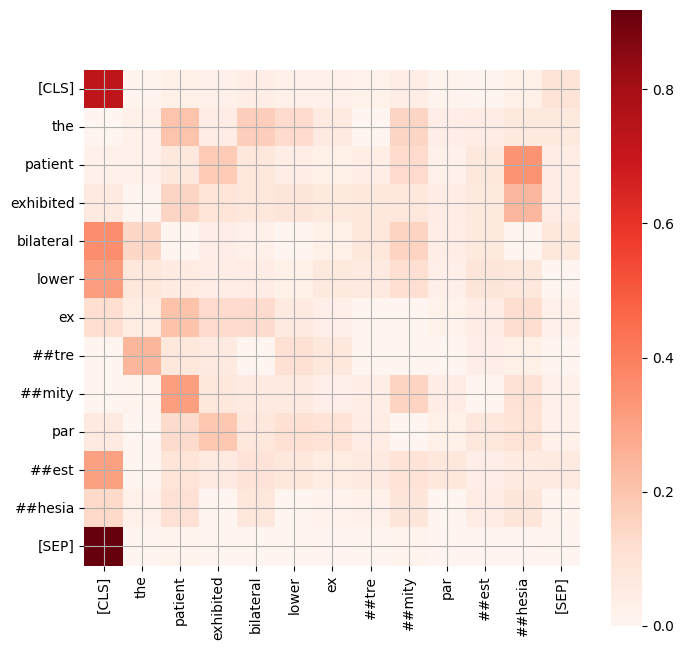

In [84]:
draw_attention_map(model, tokenizer, "The patient exhibited bilateral lower extremity paresthesia", 0, 0)

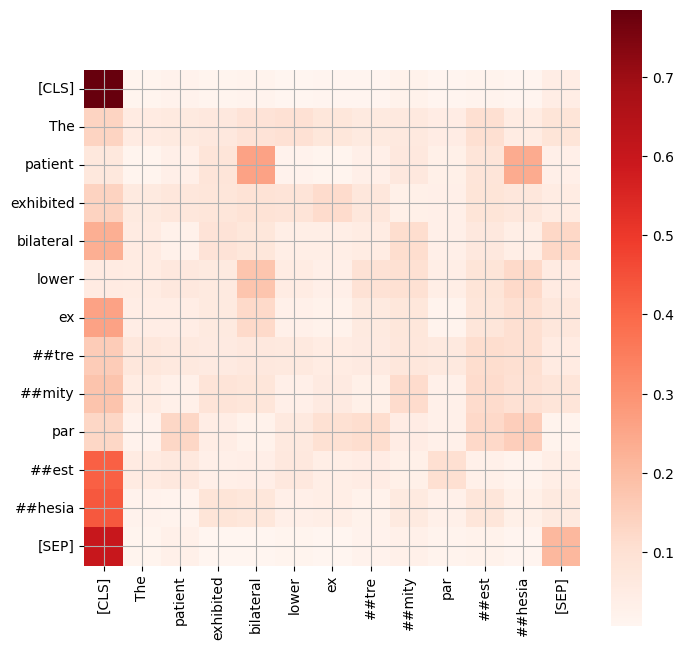

In [117]:
draw_attention_map(model_cb, tokenizer, "The patient exhibited bilateral lower extremity paresthesia", 0, 0)